<a href="https://colab.research.google.com/github/idubi-google-reichman/Data-Analysis-WillKoehrsen/blob/master/Cartpole_with_DQN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cartpole with Deep Q Network

## 1. Preparation

### 1.1. Install

In [ ]:
## Python
!python --version

Python 3.10.12


In [ ]:
## PyTorch
!python -c 'import torch; print(torch.__version__)'

2.3.1+cu121


In [ ]:
## CUDA
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# print the Nvidia description
# !nvidia-smi

Fetch relevent files and updates

In [ ]:
!apt-get update

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [910 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http:

In [ ]:
!pip install --upgrade gymnasium[classic-control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.4 MB/s eta 0:00:00


In [ ]:
## Gymnasium 0.20.0+
!python -c 'import gymnasium; print(gymnasium.__version__)'

0.29.1


### 1.2. Import

In [ ]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import pickle
import re
import csv
import math
import random
import time
import datetime

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import gymnasium as gym

In [ ]:
from collections import namedtuple
from collections import deque
from itertools import count

In [ ]:
import glob
import io
import base64
import IPython

In [ ]:
import pygame
import moviepy

In [ ]:
from typing import Optional

In [ ]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = [12, 8]

In [ ]:
plt.ion()

### 1.3. Setup

In [ ]:
project = 'cartpole'

In [ ]:
output_dir = project + '/output'
checkpoint_dir = project + '/checkpoint'

In [ ]:
!mkdir -p $output_dir
!mkdir -p $checkpoint_dir

cuda (gpu) vs. cpu

In [ ]:
if torch.cuda.is_available() :
    device = 'cuda'
    #device = 'cuda:0'
else :
    device = 'cpu'

## 2. Sample (CartPole)

### 2.1. Environment

#### 2.1.1. Environment Setup

In [ ]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [ ]:
env = gym.wrappers.RecordVideo(env, output_dir)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/cartpole/output folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
## Action Space
env.action_space

Discrete(2)

In [ ]:
## Observation Space
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [ ]:
## Reward Range
env.reward_range

(-inf, inf)

In [ ]:
state, info = env.reset(seed=random.randint(0, (2**24)))
state, info

(array([ 0.00441719, -0.01656523,  0.02479995,  0.03762722], dtype=float32),
 {})

In [ ]:
img = env.render()

System state:
* cart position
* cart velocity
* pole angle
* pole velocity

In [ ]:
state_text_01 = f'cart position = {state[0]:.2f}\n'
state_text_01 += f'cart velocity = {state[1]:.3f}'
state_text_02 = f'pole angle = {state[2]:.2f}\n'
state_text_02 += f'pole velocity = {state[3]:.3f}'
state_text_03 = f'steps = 0'

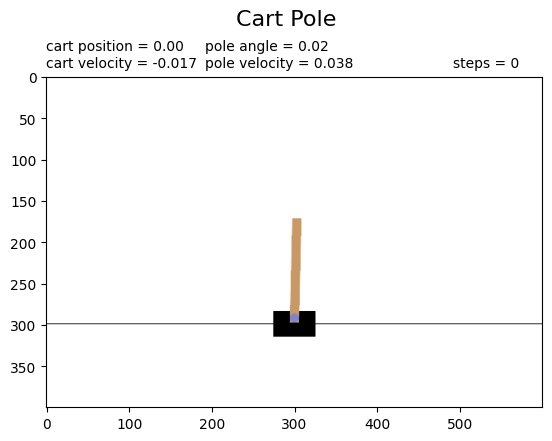

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.suptitle('Cart Pole', fontsize=16)
plt.imshow(img)
plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
plt.text(0.32, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
plt.text(0.82, 1.03, state_text_03, fontsize=10, transform=ax.transAxes)
plt.show()

### 2.2. Algorithm

#### 2.2.1. Experience Replay Memory

Experience Replay Memory is a crucial component in many reinforcement learning algorithms, allowing agents to learn more effectively from past experiences by leveraging a memory buffer to sample and replay experiences in a way that enhances learning stability and efficiency.

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [ ]:
class ReplayMemory(object) :
    # Initializes the replay memory.
    # Uses a deque (double-ended queue) with a fixed size.
    # When the deque exceeds its capacity,
    # the oldest experiences are automatically removed.

    def __init__(self, capacity) :
        self.memory = deque([], maxlen=capacity)

    # Adds a new experience to the memory.
    def push(self, *args) :
        self.memory.append(Transition(*args))

    # Randomly samples a batch of experiences from the memory.
    def sample(self, batch_size) :
        return random.sample(self.memory, batch_size)

    # Returns the current number of experiences in the memory.
    def __len__(self) :
        return len(self.memory)

#### 2.2.2. Network

##### 2.2.2.1. DQN - Multilayer Perceptron (MLP)

**Question #1: A simple NN. Try to modify to more sophisticated NN.**

In [ ]:
class DQN_MLP(nn.Module) :
    def __init__(self, n_observations, n_actions) :
        super(DQN_MLP, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    def forward(self, x) :
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

```
class DQN_CNN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.```





```
class DQN_LSTM(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN_LSTM, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.lstm = nn.LSTM(128, 128)
        self.fc2 = nn.Linear(128, n_actions)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x, hidden = self.lstm(x.view(len(x), 1, -1), hidden)
        x = self.fc2(x.view(len(x), -1))
        return x, hidden```



#### 2.2.3. Action Selection (Epsilon-Greedy Algorithm)

Selects an action based on the current state, using an epsilon-greedy strategy.

In [ ]:
def select_action(state) :
    global steps_done
    sample = random.random()

    # Calculate the current epsilon (eps_threshold) which dictates the probability of
    # taking a random action versus the best predicted action. Considering the hyperparameters.
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # Epsilon-Greedy Decision
    if sample > eps_threshold :
        with torch.no_grad() :
            return policy_net(state).max(1)[1].view(1, 1), eps_threshold
    else :
        ## Random Action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), eps_threshold

#### 2.2.4. Training Loop

The optimize_model function is designed to perform a single optimization step for a reinforcement learning agent, specifically in the context of training a Deep Q-Network (DQN).

In [ ]:
def optimize_model() :
    global state_action_values
    global loss
    if len(memory) < BATCH_SIZE : # Ensures there are enough experiences in the replay memory to form a batch.
                                  # If not, the function exits early.
        return

    # Randomly samples a batch of experiences from the replay memory and unzips
    # them into separate components (states, actions, rewards, next states).
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Computes the Q-values for the current states and selected actions
    # using the policy network.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Computes the maximum Q-values for the next states using the target network, but only for non-terminal states. The with torch.no_grad()
    # block ensures no gradients are computed for this part.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad() :
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Computes the expected Q-values using the Bellman equation.
    # GAMMA is the discount factor.
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Perform Backpropagation and Optimization
    optimizer.zero_grad() # clears the gradients of all optimized parameters
    loss.backward() # computes the gradient of the loss
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1000) #clip gradients
    optimizer.step() # update NN parameters.

#### 2.2.5. Plot Function

In [ ]:
def plot_rewards(realtime=False) :
    fig = plt.figure()
    rewards = torch.tensor(episode_rewards, dtype=torch.float)
    steps = torch.tensor(episode_steps, dtype=torch.int)
    if realtime :
        plt.clf()
        plt.suptitle('Training...')
    else :
        plt.suptitle('Training Result')
    ax1 = fig.add_subplot(2, 1, 1)
    #ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(linestyle='--')
    ax1.tick_params('x', length=0)
    ax1.plot(rewards.numpy())
    if len(rewards) >= 100 :
        bin = 100
    else :
        bin = len(rewards)
    means = rewards.unfold(0, bin, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(bin - 1) + means[0], means))
    ax1.plot(means.numpy())
    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps')
    ax2.grid(linestyle='--')
    ax2.plot(steps.numpy())
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0.10)
    plt.pause(0.001)
    if realtime :
        IPython.display.display(plt.gcf())
        IPython.display.clear_output(wait=True)
    else :
        IPython.display.display(plt.gcf())

#### 2.2.6. Utilities

In [ ]:
def atoi(text) :
    return int(text) if text.isdigit() else text

In [ ]:
def natural_keys(text) :
    return [atoi(c) for c in re.split(r'(\d+)', text)]

### 2.3. Training

#### 2.3.1. Hyperparameters
**Question #2:** Modify each one of the hyperparameters and explain how it affect the overall performance?

In [ ]:
## Q-Learning: Batch Size
BATCH_SIZE = 128

In [ ]:
## Q-Learning: Discount Factor
GAMMA = 0.99

In [ ]:
## Epsilon-Greedy Thresholds
EPS_START = 0.90
EPS_END = 0.05
EPS_DECAY = 1000

In [ ]:
## Target Network: Update Rate
TAU = 0.005

In [ ]:
## Optimizer: Learning Rate
LR = 1e-04

#### 2.3.2. Model Initialization

In [ ]:
n_actions = env.action_space.n

In [ ]:
n_observations = state.size

In [ ]:
policy_net = DQN_MLP(n_observations, n_actions).to(device)
target_net = DQN_MLP(n_observations, n_actions).to(device)

In [ ]:
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [ ]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [ ]:
memory = ReplayMemory(10000)

In [ ]:
steps_done = 0
state_action_values = np.array(0.0)
loss = 0.0

In [ ]:
episode_rewards = []
episode_steps = []

#### 2.3.3. Training

In [ ]:
num_episodes = 600

In [ ]:
num_episodes_save = 100

episode: 599, steps: 226, reward: 226.000, loss: 1.528e-03, mean_q: 1.023e+02


<Figure size 640x480 with 0 Axes>

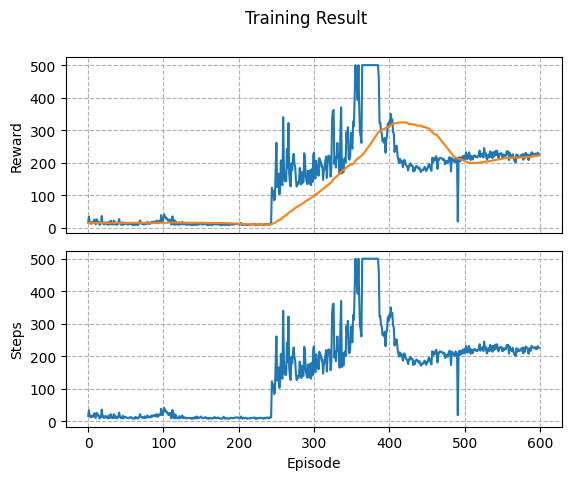

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
for i_episode in range(num_episodes) :
    state, info = env.reset(seed=random.randint(0, (2**24)))
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    reward_total = 0
    for t in count() :
        action, eps_threshold = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        reward_total += reward
        done = terminated or truncated
        if terminated :
            next_state = None
        else :
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        # In essence, TAU acts as a smoothing factor,
        # ensuring a more stable and gradual update of the target network, which is crucial for the effectiveness of DQN.

        for key in policy_net_state_dict :
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done :
            episode_rewards.append(reward_total)
            episode_steps.append(t + 1)
            print(f'episode: {i_episode}, steps: {(t + 1)}, reward: {reward_total[0]:.3f}, loss: {loss:.3e}, mean_q: {state_action_values.mean():.3e}')
            if i_episode % 20 == 0 :
                IPython.display.clear_output(wait=True)
                plot_rewards(realtime=False)
            break
    if (i_episode % num_episodes_save == 0) :
        torch.save(policy_net.state_dict(), checkpoint_dir + '/policy_net_' + str(i_episode) + '.pth')
        torch.save(target_net.state_dict(), checkpoint_dir + '/target_net_' + str(i_episode) + '.pth')
    if (i_episode == range(num_episodes)[-1]) :
        torch.save(policy_net.state_dict(), checkpoint_dir + '/policy_net_final.pth')
        torch.save(target_net.state_dict(), checkpoint_dir + '/target_net_final.pth')

IPython.display.clear_output(wait=True)
print(f'episode: {i_episode}, steps: {(t + 1)}, reward: {reward_total[0]:.3f}, loss: {loss:.3e}, mean_q: {state_action_values.mean():.3e}')
plot_rewards()

#### 2.3.4. Video Output

In [ ]:
mp4list = glob.glob(output_dir + '/rl-video-episode-*.mp4')
if len(mp4list) > 0 :
    for mp4 in sorted(mp4list, key=natural_keys)[::(len(mp4list) - 1 if len(mp4list) >= 2 else 1)] :
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        IPython.display.display(IPython.display.HTML(data='''{mp4}<br>
            <video alt="{mp4}" autoplay loop controls style="height: 200px;">
            <source src="data:video/mp4;base64,{src}" type="video/mp4">
            </video>'''.format(mp4=mp4, src=encoded.decode('ascii'))))

### 2.4. Play

#### 2.4.1. Trained Model

In [ ]:
#env = gym.make('CartPole-v0', render_mode='rgb_array')
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [ ]:
env = gym.wrappers.RecordVideo(env, output_dir, name_prefix='play-video')
#env = gym.wrappers.RecordVideo(env, output_dir, episode_trigger=(lambda ep: ep == 0 or ep == 9 or ep % 100 == 99), name_prefix='play-video')

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/cartpole/output folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
n_actions = env.action_space.n

In [ ]:
state, info = env.reset(seed=random.randint(0, (2**24)))

In [ ]:
#n_observations = len(state)
n_observations = state.size

In [ ]:
policy_net = DQN_MLP(n_observations, n_actions).to(device)

In [ ]:
pthlist = glob.glob(checkpoint_dir + '/policy_net_*.pth')
pthfile = sorted(pthlist, key=natural_keys)[-1]
pthfile

'cartpole/checkpoint/policy_net_final.pth'

In [ ]:
policy_net.load_state_dict(torch.load(pthfile))

<All keys matched successfully>

In [ ]:
policy_net.eval()

DQN_MLP(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

#### 2.4.2. Play

steps: 231Moviepy - Building video /content/cartpole/output/play-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole/output/play-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole/output/play-video-episode-0.mp4


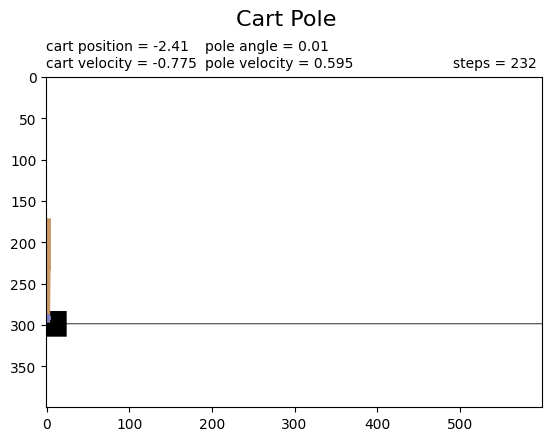

In [ ]:
# Reset the environment with a random seed and get the initial state and info.
state, info = env.reset(seed=random.randint(0, (2**24)))


# Store the initial state as observation.
observation = state

# Convert the state to a PyTorch tensor and move it to the device (CPU or GPU).
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

steps = 0 # Initialize the number of steps taken.
ims = [] # Initialize a list to store images for animation.
fig = plt.figure()  # Create a matplotlib figure for visualization.
ax = fig.add_subplot(1, 1, 1)
plt.suptitle('Cart Pole', fontsize=16)

## Initial Frame
# Create text to display the initial state of the cart and pole.

state_text_01 = f'cart position = {observation[0]:.2f}\n'
state_text_01 += f'cart velocity = {observation[1]:.3f}'
state_text_02 = f'pole angle = {observation[2]:.2f}\n'
state_text_02 += f'pole velocity = {observation[3]:.3f}'
state_text_03 = f'steps = {steps}'
img = env.render()
image = plt.imshow(img, animated=True)
text_01 = plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
text_02 = plt.text(0.32, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
text_03 = plt.text(0.82, 1.03, state_text_03, fontsize=10, transform=ax.transAxes)
ims.append([image] + [text_01] + [text_02] + [text_03])
plt.gca().texts[-1].set_visible(False)
plt.gca().texts[-2].set_visible(False)
plt.gca().texts[-3].set_visible(False)

while True :
    print('\r' + 'steps: ' + str(steps), end='')
    action = policy_net(state).max(1)[1].view(1, 1)
    observation, reward, terminated, truncated, info = env.step(action.item())
    steps += 1
    state_text_01 = f'cart position = {observation[0]:.2f}\n'
    state_text_01 += f'cart velocity = {observation[1]:.3f}'
    state_text_02 = f'pole angle = {observation[2]:.2f}\n'
    state_text_02 += f'pole velocity = {observation[3]:.3f}'
    state_text_03 = f'steps = {steps}'
    img = env.render()
    image = plt.imshow(img, animated=True)
    text_01 = plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
    text_02 = plt.text(0.32, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
    text_03 = plt.text(0.82, 1.03, state_text_03, fontsize=10, transform=ax.transAxes)
    ims.append([image] + [text_01] + [text_02] + [text_03])
    plt.gca().texts[-1].set_visible(False)
    plt.gca().texts[-2].set_visible(False)
    plt.gca().texts[-3].set_visible(False)
    done = terminated or truncated
    if terminated :
        next_state = None
    else :
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    state = next_state
    if done :
        plt.gca().texts[-1].set_visible(True)
        plt.gca().texts[-2].set_visible(True)
        plt.gca().texts[-3].set_visible(True)
        break

#### 2.4.3. Video Output

In [ ]:
mp4list = glob.glob(output_dir + '/play-video-episode-*.mp4')
if len(mp4list) > 0 :
    for mp4 in sorted(mp4list, key=natural_keys)[::(len(mp4list) - 1 if len(mp4list) >= 2 else 1)] :
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        IPython.display.display(IPython.display.HTML(data='''{mp4}<br>
            <video alt="{mp4}" autoplay loop controls style="height: 200px;">
            <source src="data:video/mp4;base64,{src}" type="video/mp4">
            </video>'''.format(mp4=mp4, src=encoded.decode('ascii'))))

#### 2.4.4. GIF Output

In [ ]:
gif = output_dir + '/play-video-episode-0.gif'

In [ ]:
#fig.set_size_inches(6.4, 4.8, forward=True)

In [ ]:
ani = matplotlib.animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save(gif, writer="pillow")

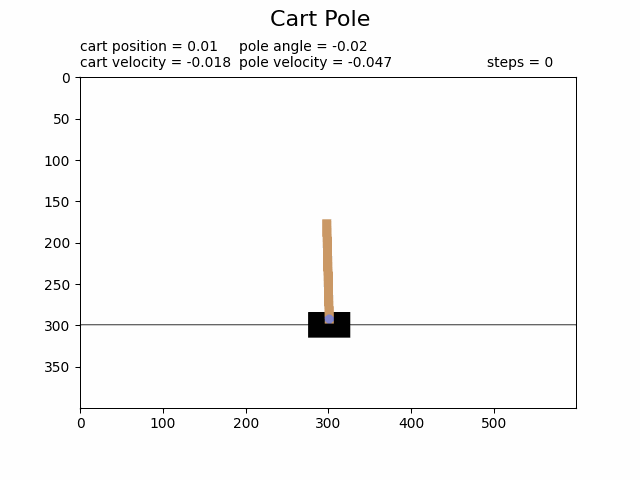

In [ ]:
IPython.display.Image(gif, format='gif')